In [16]:
import os
import random
import warnings
import numpy as np
import pylab as py
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from matplotlib.patches import Patch

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [17]:
## IGOR_OUTPUT
def generate_igor(x_label, x_data, y_label, y_data, plot_save):
    if not any([x_label, x_data, y_label, y_data]):
        return
    igor_save = plot_save[:-3] + 'itx'
    with open(igor_save, 'w') as fh:
        for L in [x_label, y_label]:
            for i in range(len(L)):
                L[i] = "'" + str(L[i]) + "'"
        header = 'IGOR\rWAVES/D\t' + '\t'.join(map(str, x_label + y_label)) + '\rBEGIN\r'
        fh.write(header)
        if not isinstance(x_data, list):
            x_data = np.ndarray.tolist(x_data)
        if not isinstance(y_data, list):
            y_data = np.ndarray.tolist(y_data)
        L_data = x_data + y_data
        max_i = max(len(col) for col in L_data)
        for i in range(max_i):
            row = []
            for col in L_data:
                row.append(str(col[i]) if i < len(col) and col[i] is not None else 'NAN')
            fh.write('\t'.join(row) + '\r')
        fh.write('END')


In [18]:
## GLOBALS
main_dir = os.getcwd() + r'\\'
shuffled_data_name = main_dir + 'match_vectors_no_label_shuffled.csv'
FEATURE_LABEL = [
    'h_roster_rating','h_gk_rating','h_def_rating','h_mid_rating','h_off_rating',
    'a_roster_rating','a_gk_rating','a_def_rating','a_mid_rating','a_off_rating','label'
]
FIGURE_SIZE = (8, 8)
DPI = 150


In [19]:
## DATA_FUNCTIONS
def add_x0(x):
    return np.hstack((np.ones((x.shape[0], 1)), x))

def define_xy(data, L_i, ratio=0.8, add_zero=True):
    cols = list(L_i)
    x = add_x0(data[:, cols]) if add_zero else data[:, cols]
    y = data[:, -1]
    split = int(len(y) * ratio)
    return x[:split], y[:split], x[split:], y[split:]

def arrange_data(file_name, L_i):
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"{file_name} not found")
    data = np.genfromtxt(file_name, delimiter=',')
    if data.ndim == 1:
        data = data.reshape(1, -1)
    x_train, y_train, x_test, y_test = define_xy(data, L_i, ratio=0.8, add_zero=False)
    return x_train, y_train, x_test, y_test


In [20]:
## GDA_FUNCTIONS
def _safe_cov(X, reg=1e-6):
    if X.size == 0:
        return np.eye(1) * reg
    cov = np.cov(X, rowvar=False)
    if cov.ndim == 0:
        cov = np.array([[cov]])
    n = cov.shape[0]
    cov += np.eye(n) * reg
    return cov

def get_mu_sigma_phi(x_train, y_train):
    mu, sigma, phi = [], [], []
    for label in [1, 0, -1]:
        Xc = x_train[y_train == label]
        if Xc.size == 0:
            mu.append(np.zeros(x_train.shape[1]))
            sigma.append(np.eye(x_train.shape[1]) * 1e-6)
            phi.append(0.0)
        else:
            mu.append(np.mean(Xc, axis=0))
            sigma.append(_safe_cov(Xc))
            phi.append(np.mean(y_train == label))
    return mu, sigma, phi

def Gaussian_point(x, mu, sigma):
    inv = np.linalg.inv(sigma)
    det = np.linalg.det(sigma)
    k = len(mu)
    coef = 1.0 / ((2 * np.pi) ** (k / 2) * (det ** 0.5))
    diff = x - mu
    val = coef * np.exp(-0.5 * diff @ inv @ diff.T)
    return val

def decide_GDA(x_i, phi, mu, sigma):
    probs = np.array([Gaussian_point(x_i, mu[j], sigma[j]) * phi[j] for j in range(len(phi))])
    s = probs.sum()
    if s == 0:
        probs = np.ones_like(probs) / len(probs)
    else:
        probs = probs / s
    label = [1, 0, -1][np.argmax(probs)]
    return probs, label

def predict_GDA(mu, sigma, phi, x, y):
    preds = np.array([decide_GDA(x[i], phi, mu, sigma)[1] for i in range(len(y))])
    acc = np.mean(preds == y) if len(y) > 0 else np.nan
    print(f"GDA Accuracy: {acc:.4f}")
    return preds


In [21]:
## PLOT_FUNCTIONS
def _compute_range(arr, pad=0.05):
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    span = mx - mn
    if span == 0:
        mn -= 0.5
        mx += 0.5
    else:
        mn -= span * pad
        mx += span * pad
    return mn, mx

def plot_results(x_unscaled, y_true, y_pred, i_x0, i_x1, title, d_feature, figsize=FIGURE_SIZE, dpi=DPI):
    idx0 = d_feature[i_x0]
    idx1 = d_feature[i_x1]
    x0 = x_unscaled[:, idx0]
    x1 = x_unscaled[:, idx1]
    x0min, x0max = _compute_range(x0)
    x1min, x1max = _compute_range(x1)
    fig, axs = py.subplots(2, 2, figsize=figsize, dpi=dpi)
    scatter_args = dict(cmap=py.cm.coolwarm, s=30, edgecolors='k')
    axs[0,0].scatter(x0, x1, c=y_pred, **scatter_args)
    axs[0,0].set_title("Predicted")
    axs[0,1].scatter(x0, x1, c=y_true, **scatter_args)
    axs[0,1].set_title("Actual")
    mask_correct = y_pred == y_true
    axs[1,0].scatter(x0[mask_correct], x1[mask_correct], c=y_true[mask_correct], **scatter_args)
    axs[1,0].set_title("Correct")
    mask_incorrect = ~mask_correct
    axs[1,1].scatter(x0[mask_incorrect], x1[mask_incorrect], c=y_true[mask_incorrect], **scatter_args)
    axs[1,1].set_title("Incorrect")
    for ax in axs.ravel():
        ax.set_xlim(x0min, x0max)
        ax.set_ylim(x1min, x1max)
        ax.set_xlabel(FEATURE_LABEL[i_x0])
        ax.set_ylabel(FEATURE_LABEL[i_x1])
    handles = [Patch(facecolor=py.cm.coolwarm((v+1)/3.0), label=l) for v,l in zip([ -1, 0, 1], ['loss','draw','win'])]
    fig.legend(handles=handles, loc='lower center', ncol=3)
    fig.suptitle(title, fontsize=14)
    py.tight_layout(rect=[0, 0.03, 1, 0.95])
    py.savefig(f"{title}.png", dpi=dpi)
    py.show()
    py.close()


In [22]:
## SVM_RUN
def run_SVM(x_train_unscaled, y_train, x_test_unscaled, y_test, i_x0, i_x1, d_feature, kernel='rbf', degree=3, title='SVM'):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_unscaled)
    x_test_scaled = scaler.transform(x_test_unscaled)
    if kernel == 'poly':
        clf = SVC(kernel='poly', degree=degree, gamma='scale', coef0=1.0, C=1.0, max_iter=10000)
    else:
        clf = SVC(kernel=kernel, gamma='scale', max_iter=10000)
    clf.fit(x_train_scaled, y_train)
    preds = clf.predict(x_test_scaled)
    acc = np.mean(preds == y_test) if len(y_test) > 0 else np.nan
    print(f"{kernel.upper()} Accuracy: {acc:.4f}")
    plot_results(x_test_unscaled, y_test, preds, i_x0, i_x1, title, d_feature)
    return preds


Shapes: x_train (3032, 2) y_train (3032,) x_test (759, 2) y_test (759,)
First rows x_train:
 [[7.00285714 6.66928571]
 [6.93357143 6.76428571]
 [6.67857143 6.51461538]
 [6.72384615 6.67428571]
 [6.80642857 7.00461539]]
GDA Accuracy: 0.5850


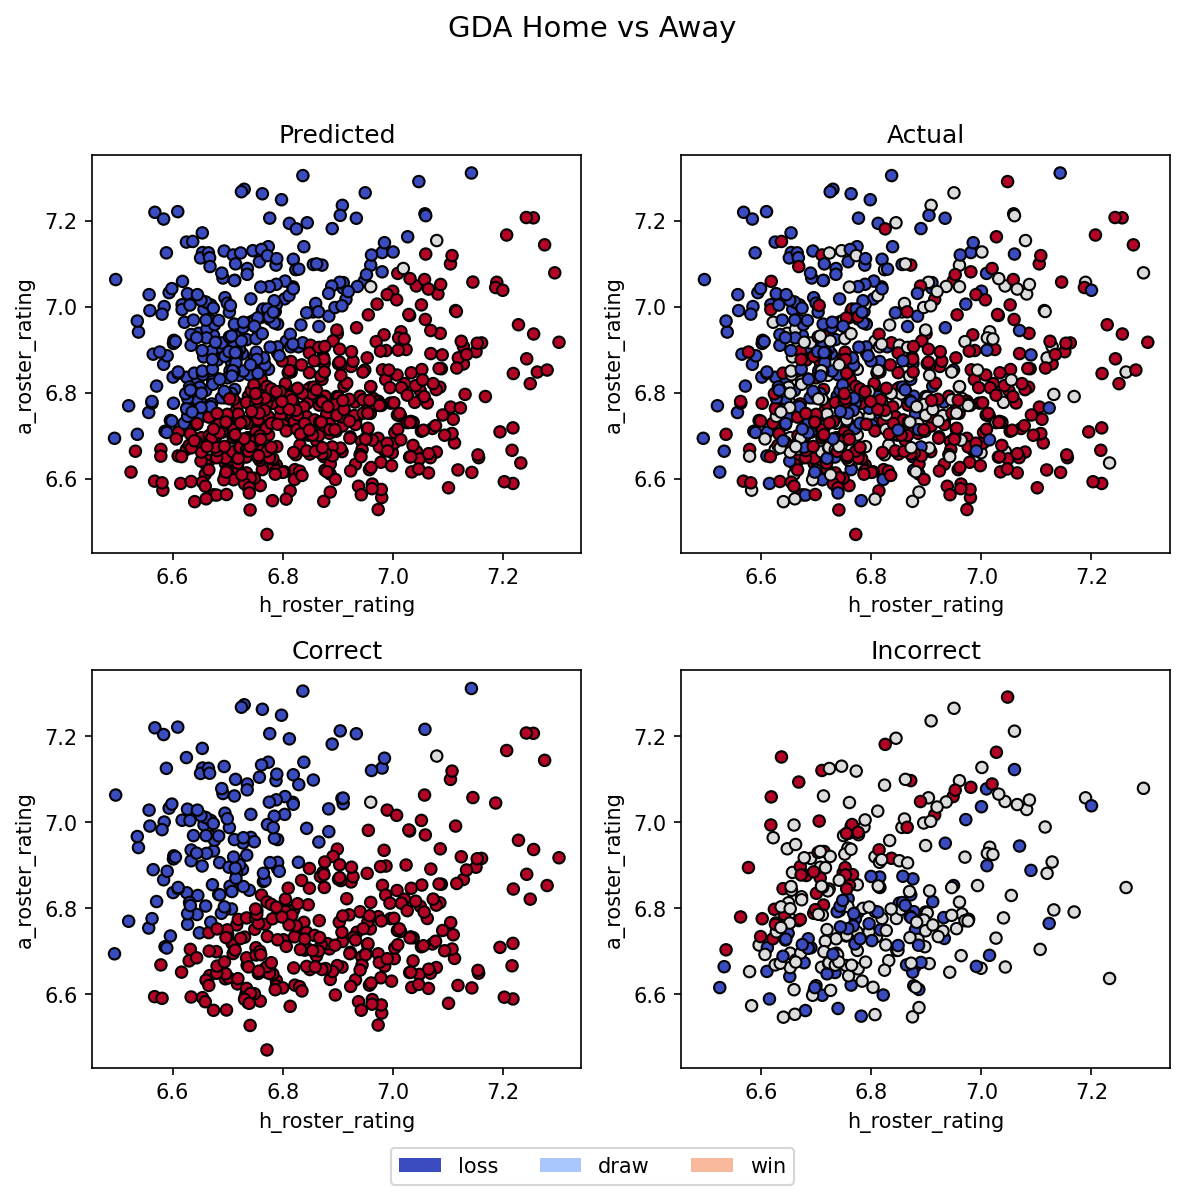

LINEAR Accuracy: 0.5863


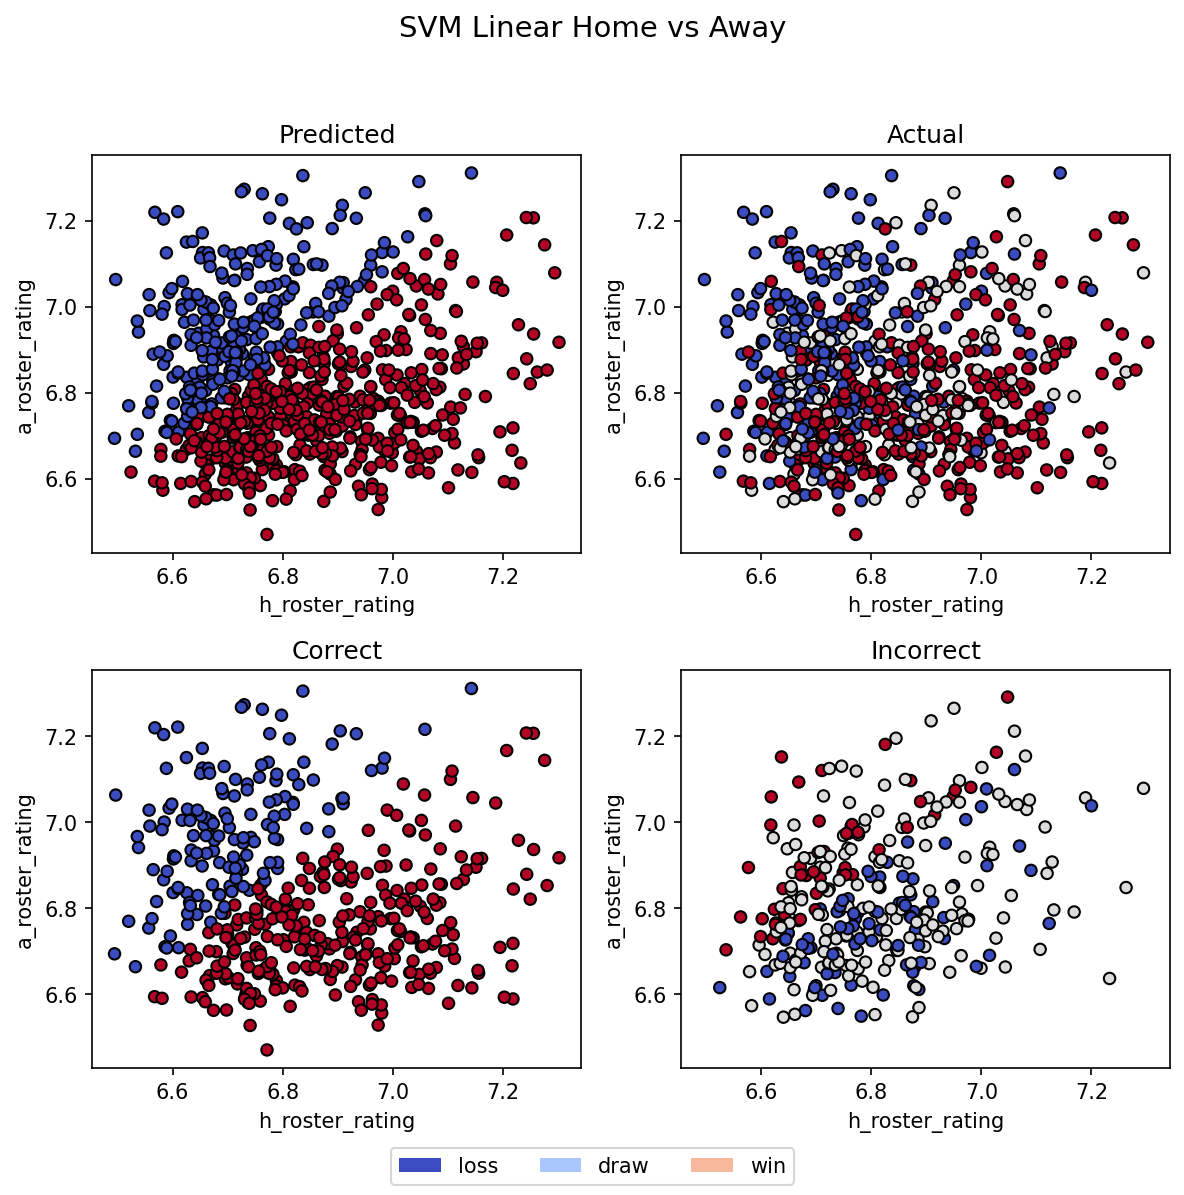

RBF Accuracy: 0.5837


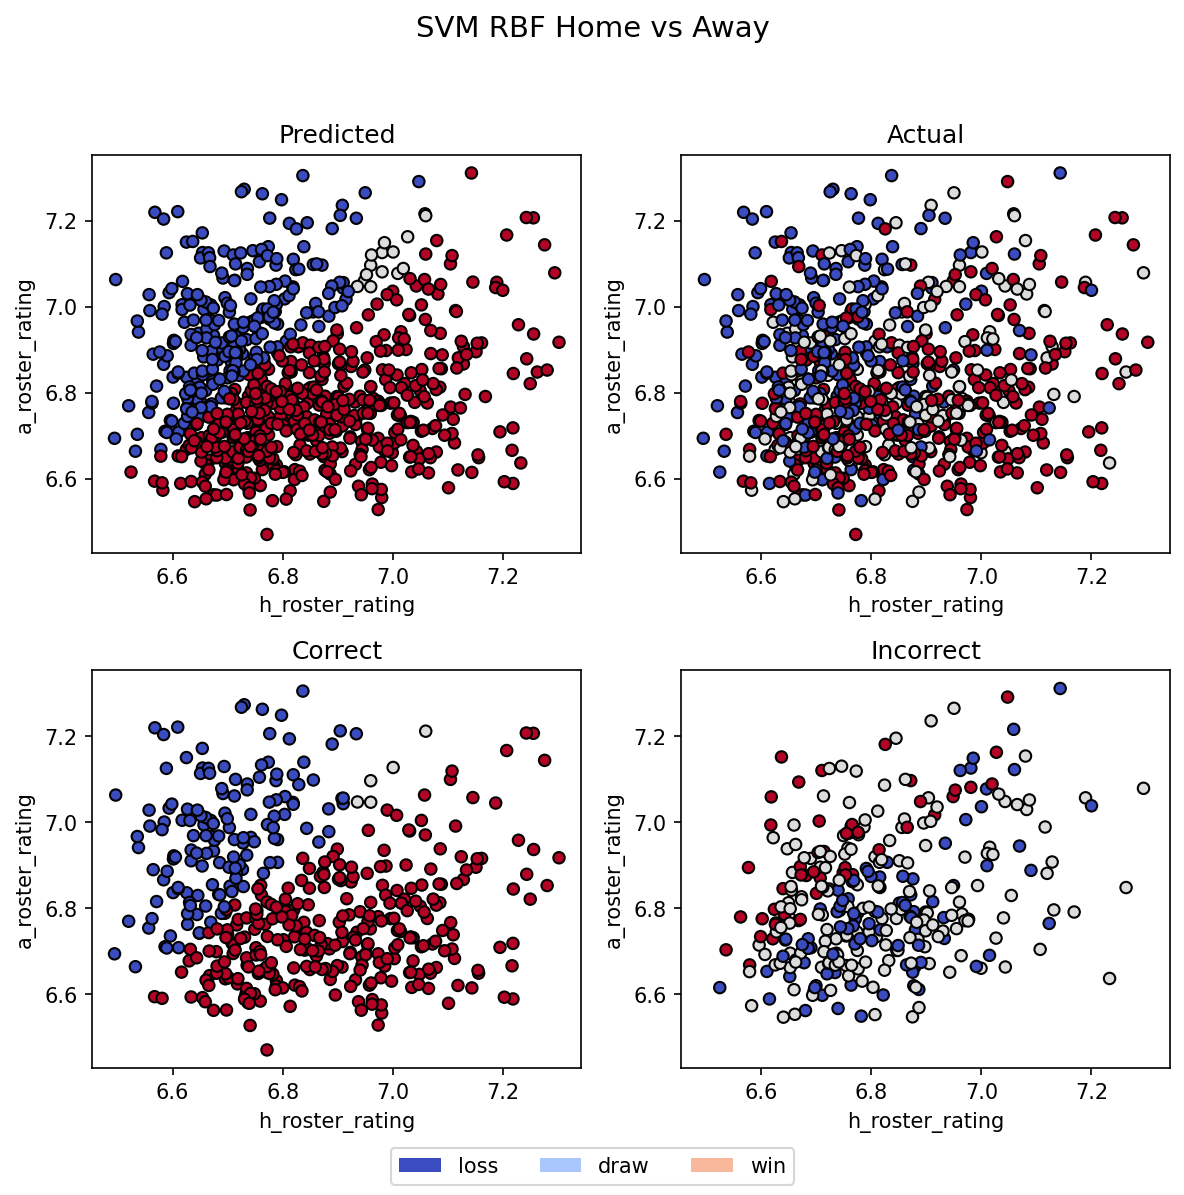

POLY Accuracy: 0.5850


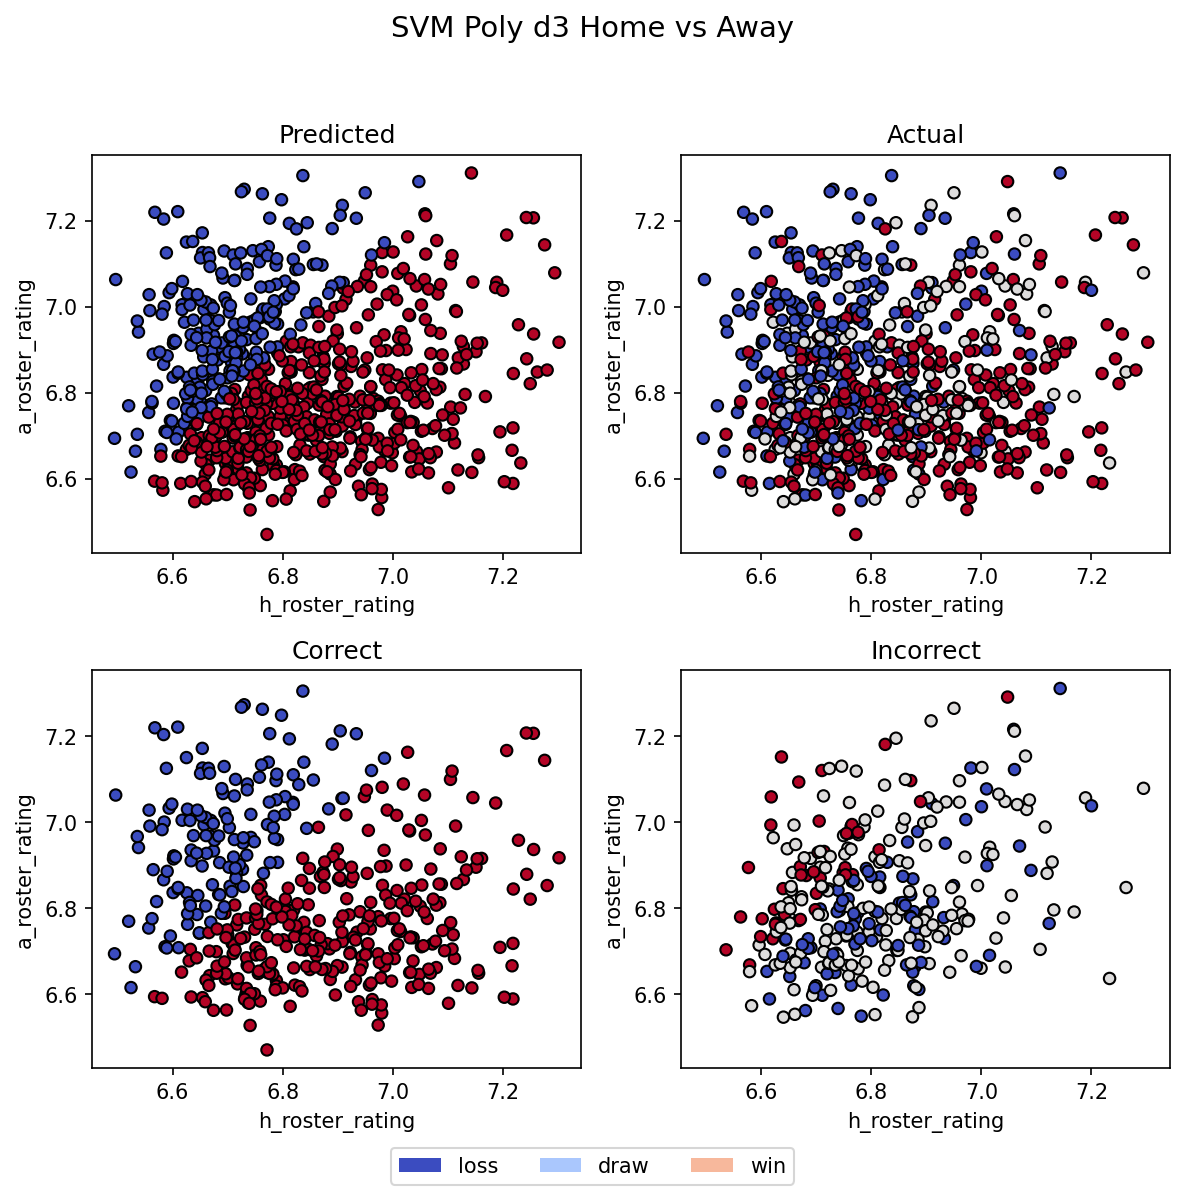

In [23]:
## MAIN
if __name__ == '__main__':
    L_feature = [0, 5]
    x_train, y_train, x_test, y_test = arrange_data(shuffled_data_name, L_feature)
    print("Shapes:", "x_train", x_train.shape, "y_train", y_train.shape, "x_test", x_test.shape, "y_test", y_test.shape)
    print("First rows x_train:\n", x_train[:5])
    d_feature = {feat: idx for idx, feat in enumerate(L_feature)}
    mu, sigma, phi = get_mu_sigma_phi(x_train, y_train)
    preds_gda = predict_GDA(mu, sigma, phi, x_test, y_test)
    plot_results(x_test, y_test, preds_gda, L_feature[0], L_feature[1], 'GDA Home vs Away', d_feature)
    run_SVM(x_train, y_train, x_test, y_test, L_feature[0], L_feature[1], d_feature, kernel='linear', title='SVM Linear Home vs Away')
    run_SVM(x_train, y_train, x_test, y_test, L_feature[0], L_feature[1], d_feature, kernel='rbf', title='SVM RBF Home vs Away')
    run_SVM(x_train, y_train, x_test, y_test, L_feature[0], L_feature[1], d_feature, kernel='poly', degree=3, title='SVM Poly d3 Home vs Away')
